In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

T = 80
alpha = 0.3
beta = 2.0
pra = 0.7
prb = 0.3

ra = tfp.distributions.Bernoulli(probs=pra, dtype=tf.float32)
rb = tfp.distributions.Bernoulli(probs=prb, dtype=tf.float32)
Q = np.zeros((2, T+1), dtype=np.float32)
choices = np.zeros((T, ), dtype=np.int32)
rewards = np.zeros((T, ), dtype=np.float32)
pahist = np.zeros((T+1, ), dtype=np.float32)

for t in range(1, T):
    pa = 1. / (1 + tf.exp(-beta * (Q[0, t] - Q[1, t])))
    pahist[t+1] = pa
    a = tfp.distributions.Bernoulli(probs=pa, dtype=tf.bool).sample(1)[0]
    choices[t] = a
    if a == True:
        r = ra.sample(1)[0]
        Q[0, t+1] = Q[0, t] + alpha * (r - Q[0, t]) 
        Q[1, t+1] = Q[1, t]
    else:
        r = rb.sample(1)[0]
        Q[1, t+1] = Q[1, t] + alpha * (r - Q[1, t]) 
        Q[0, t+1] = Q[0, t]
    rewards[t] = r

2021-08-18 23:21:35.845554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-18 23:21:35.853175: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-18 23:21:37.770080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-18 23:21:37.770123: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-18 23:21:37.770156: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-26-3-85): /proc/driver/nvidia/version does not exist
2021-08-18 23:21:37.770444: I tensorflow/core/platform/cpu_fea

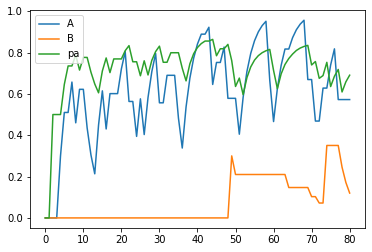

In [2]:
plt.plot(range(T+1), Q[0, :], label='A')
plt.plot(range(T+1), Q[1, :], label='B')
plt.plot(range(T+1), pahist, label='pa')
plt.legend()
plt.show()

In [7]:
import functools

T = 80

def make_val_and_grad_fn(value_fn):
    @functools.wraps(value_fn)
    def val_and_grad(x):
        return tfp.math.value_and_gradient(value_fn, x)
    return val_and_grad

@make_val_and_grad_fn
def simulate(params):
    tf.print(params)
    alpha_est, beta_est = tf.exp(params[0]), tf.exp(params[1])
    Qa = np.array(0.0, dtype=np.float32)
    Qb = np.array(0.0, dtype=np.float32)
    ll = tf.Variable(0.0, dtype=np.float32)

    alpha_prior = tfp.distributions.Beta(2.0, 2.0)
    beta_prior = tfp.distributions.Gamma(2.0, 0.3333)

    for t in range(T):
        pa = 1. / (1 + tf.exp(-beta_est * (Qa- Qb)))
        pa = tf.clip_by_value(pa, 0.00001, 0.99999)
        ll = ll + choices[t] * tf.math.log(pa) + (1 - choices[t]) * tf.math.log(1 - pa)

        if choices[t] == 1:
            Qa = Qa + alpha_est * (rewards[t] - Qa)
        else:
            Qb = Qb + alpha_est * (rewards[t] - Qb)
    tf.print(ll)
    return -ll - alpha_prior.log_prob(tf.clip_by_value(alpha_est, 0.00001, 0.99999)) - beta_prior.log_prob(tf.clip_by_value(beta_est, 0.00001, np.finfo(np.float32).max - 0.00001))

alpha_est = 0.
beta_est = 0.

optim_results = tfp.optimizer.lbfgs_minimize(
    simulate, initial_position=np.array([alpha_est, beta_est], dtype=np.float32))

[0 0]
-47.2172699


ValueError: Invalid integer data type 'f'.

In [6]:
np.exp(optim_results.position.numpy())

array([0.42951652, 1.8518397 ], dtype=float32)